In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import shap
import os
import shutil
import random

In [10]:
MODEL_SAVE_PATH = 'models/plant_disease_model_resnet50.h5'
CLASS_NAMES_PATH = 'class_names.py'
IMAGE_SAVE_DIR = "images/"
os.makedirs(IMAGE_SAVE_DIR, exist_ok=True)
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

In [3]:
DATA_DIR = '../Plant_leave_diseases_dataset_without_augmentation'
BASE_DIR = '../Plant_leave_diseases_dataset_split'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

classes = os.listdir(DATA_DIR)
for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)
    n_test = n_total - n_train - n_val
    
    # Créer les dossiers
    for split, split_dir in zip(['train','val','test'], [TRAIN_DIR, VAL_DIR, TEST_DIR]):
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)
    
    # Copier les images
    for i, img in enumerate(images):
        src = os.path.join(cls_path, img)
        if i < n_train:
            dst = os.path.join(TRAIN_DIR, cls, img)
        elif i < n_train + n_val:
            dst = os.path.join(VAL_DIR, cls, img)
        else:
            dst = os.path.join(TEST_DIR, cls, img)
        shutil.copy(src, dst)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 19425 images belonging to 26 classes.
Found 6470 images belonging to 26 classes.
Found 6493 images belonging to 26 classes.


In [7]:
def build_model(num_classes):
    base_model = ResNet50(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Geler le backbone pour l'entraînement initial

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='disease_classifier_resnet50')
    return model, base_model

model, resnet_base = build_model(train_generator.num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "disease_classifier_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,118,938 (92.01 MB)

 Trainable params: 531,226 (2.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
callbacks = [
    EarlyStopping(patience=8, monitor='val_accuracy', restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.7371 - loss: 0.9534  
Epoch 1: val_accuracy improved from None to 0.97233, saving model to models/plant_disease_model_resnet50.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - accuracy: 0.8532 - loss: 0.4958 - val_accuracy: 0.9723 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 2/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9375 - loss: 0.1946  
Epoch 2: val_accuracy improved from 0.97233 to 0.97728, saving model to models/plant_disease_model_resnet50.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 589s 969ms/step - accuracy: 0.9429 - loss: 0.1788 - val_accuracy: 0.9773 - val_loss: 0.0783 - learning_rate: 0.0010
Epoch 3/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9519 - loss: 0.1415  
Epoch 3: val_accuracy improved from 0.97728 to 0.98223, saving model to models/plant_disease_model_resnet50.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 595s 979ms/step - accuracy: 0.9505 - loss: 0.1454 - val_accuracy: 0.9822 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 4/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.9545 - loss: 0.1351  
Epoch 4: val_accuracy did not improve from 0.98223
608/608 ━━━━━━━━━━━━━━━━━━━━ 585s 963ms/step - accuracy: 0.9532 - loss: 0.1359 - val_accuracy: 0.9767 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 5/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9605 - loss: 0.1213  
Epoch 5: val_accuracy did not improve from 0.98223
608/608 ━━━━━━━━━━━━━━━━━━━━ 575s 945ms/step - accuracy: 0.9598 - loss: 0.1248 - val_accuracy: 0.9815 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 6/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9586 - loss: 0.1169  
Epoch 6: val_accuracy improved from 0.98223 to 0.98609, saving model to models/plant_disease_model_resnet50.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 906s 1s/step - accuracy: 0.9599 - loss: 0.1134 - val_accuracy: 0.9861 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 7/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9619 - loss: 0.1028  
Epoch 7: val_accuracy did not improve from 0.98609
608/608 ━━━━━━━━━━━━━━━━━━━━ 925s 2s/step - accuracy: 0.9622 - loss: 0.1094 - val_accuracy: 0.9856 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 8/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9601 - loss: 0.1185      
Epoch 8: val_accuracy improved from 0.98609 to 0.98702, saving model to models/plant_disease_model_resnet50.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 4061s 7s/step - accuracy: 0.9627 - loss: 0.1108 - val_accuracy: 0.9870 - val_loss: 0.0490 - learning_rate: 0.0010
Epoch 9/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9618 - loss: 0.1074  
Epoch 9: val_accuracy did not improve from 0.98702
608/608 ━━━━━━━━━━━━━━━━━━━━ 577s 926ms/step - accuracy: 0.9656 - loss: 0.0985 - val_accuracy: 0.9847 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 10/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.9674 - loss: 0.0886  
Epoch 10: val_accuracy did not improve from 0.98702
608/608 ━━━━━━━━━━━━━━━━━━━━ 589s 969ms/step - accuracy: 0.9664 - loss: 0.0946 - val_accuracy: 0.9833 - val_loss: 0.0620 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.


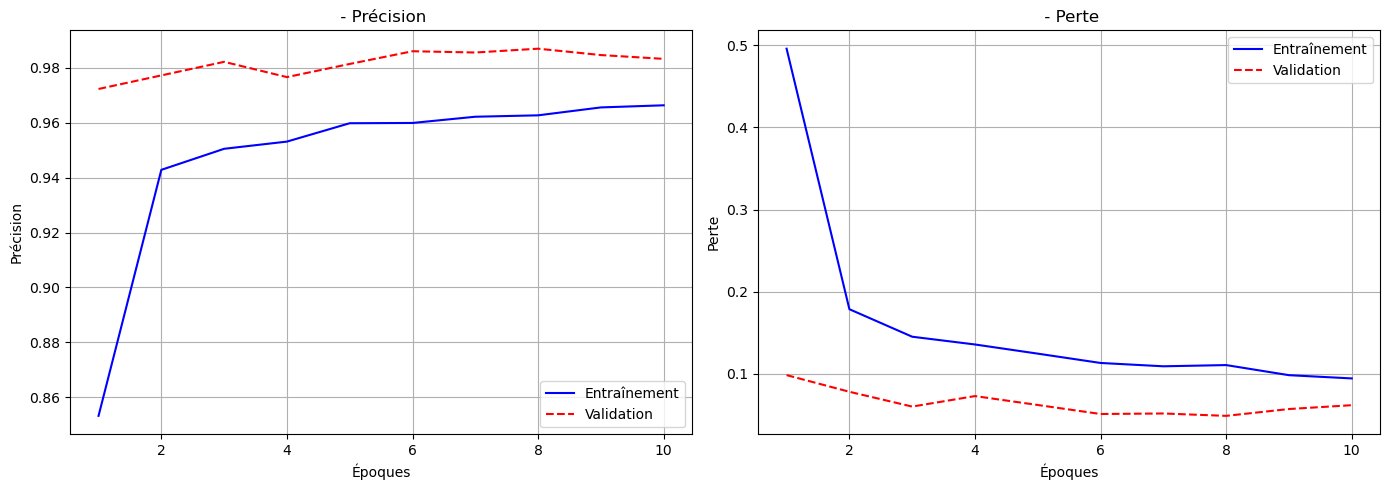

In [13]:
title_prefix=""
filename_prefix="curve"
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
    
plt.figure(figsize=(14, 5))
    
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Entraînement')
plt.plot(epochs, val_acc, 'r--', label='Validation')
plt.title(f'{title_prefix} - Précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)
    
# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Entraînement')
plt.plot(epochs, val_loss, 'r--', label='Validation')
plt.title(f'{title_prefix} - Perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)
    
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_SAVE_DIR, f"{filename_prefix}.png"))
plt.show()


In [15]:
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
class_names = [index_to_class[i] for i in range(len(index_to_class))]

with open(CLASS_NAMES_PATH, 'w') as f:
    f.write(f"class_names = {class_names}\n")


203/203 ━━━━━━━━━━━━━━━━━━━━ 129s 637ms/step


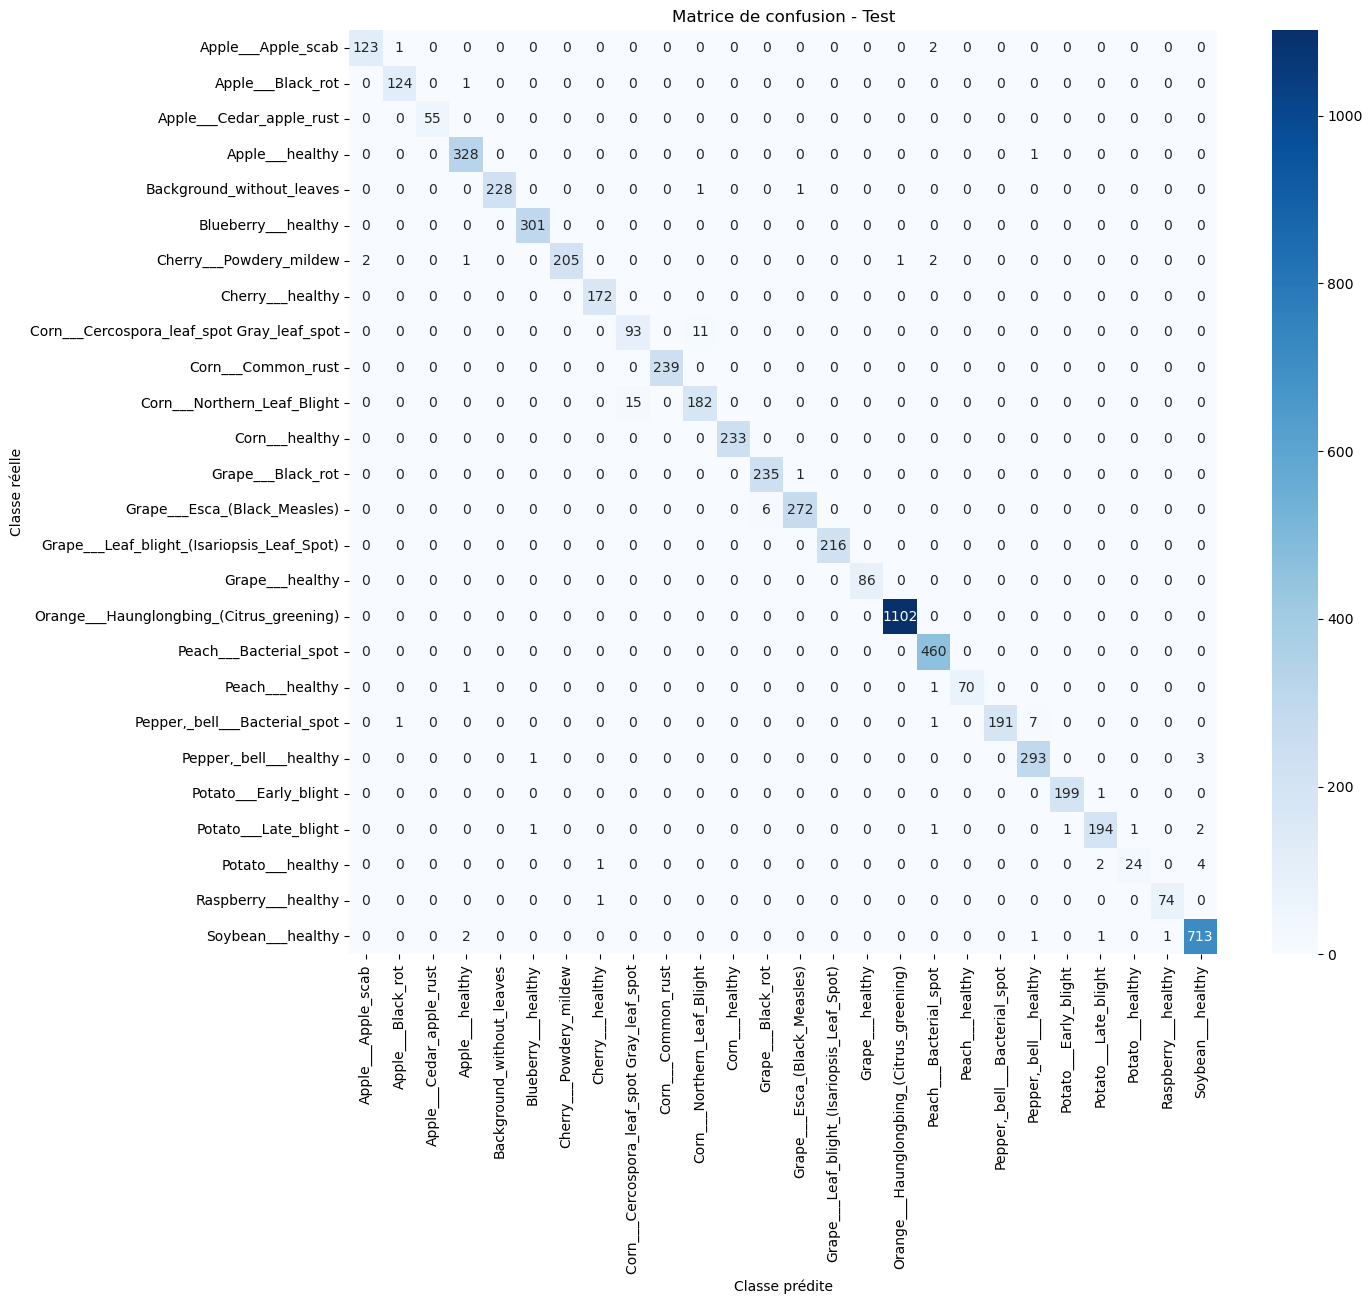

                                            precision    recall  f1-score   support

                        Apple___Apple_scab       0.98      0.98      0.98       126
                         Apple___Black_rot       0.98      0.99      0.99       125
                  Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                           Apple___healthy       0.98      1.00      0.99       329
                 Background_without_leaves       1.00      0.99      1.00       230
                       Blueberry___healthy       0.99      1.00      1.00       301
                   Cherry___Powdery_mildew       1.00      0.97      0.99       211
                          Cherry___healthy       0.99      1.00      0.99       172
Corn___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.89      0.88       104
                        Corn___Common_rust       1.00      1.00      1.00       239
               Corn___Northern_Leaf_Blight       0.94      0.92      0.93  

In [16]:
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion - Test')
plt.show()

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [ ]:
model.save("models/plant_disease_modell_resnet50.keras")